Top: CPU Utilization plot
Bottom: Memory Usage plot
done!


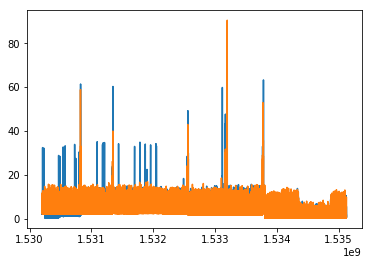

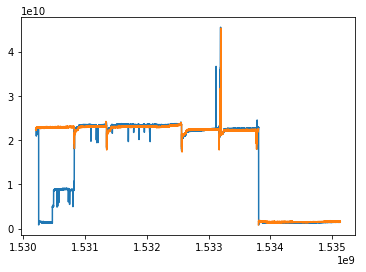

In [82]:
import wavefront_api_client as wave_api
import time
import re
import pandas as pd
import numpy as np
import sys


#DO NOT CHANGE
base_url = 'https://intuit.wavefront.com'

#change to your own api token from in wavefront
api_key = '06258b32-5ada-4485-8e78-886faf7a938b'

#cpu metric to scrape
#will return % utilization of cpu all sources matching tags
cpu_query = '100 - rate(ts("collectd.aggregation-cpu-average.cpu-idle", bu=sbg and env=prd and app=qbo and pool=app and location=qcy and source=pprdqboas83b.ie.intuit.net or source=pprdqboas83y.ie.intuit.net))'

#memory metric to scrape
#will return memory utilization for all sources matching tags
memory_query = 'ts("collectd.memory.memory-used", bu=sbg and app=qbo and env=prd and pool=app and location=qcy and source=pprdqboas83b.ie.intuit.net or source=pprdqboas83y.ie.intuit.net)'

#change to give the desired destination for resulting csv file
path_to_save_cpu = './cpu_data.csv'
path_to_save_memory = './memory_data.csv'

#time in hours to capture in query window
#  easiest to multiply it out for longer periods
#    eg. 1 week = 7 (days/week) * 24 (hours/day)
query_window = 24*7*8

#calculate start and end times in ms
end_time = time.time() * 1000
start_time = (end_time) - (query_window * 60 * 60) * 1000

#desired query granularity (s, m, h, or d)
query_granularity = 'm'

#data frames to store results in and plot from, eventually stored as csv
cpu_df = pd.DataFrame()
memory_df = pd.DataFrame()


def main():
    #set up python Wavefront client
    config = wave_api.Configuration()
    config.host = base_url
    client = wave_api.ApiClient(configuration=config, header_name='Authorization', header_value='Bearer ' + api_key)
    
    #make cpu query and plot those results
    executeQuery(cpu_query, client, 'cpu')
    print('Top: CPU Utilization plot')
    print('Bottom: Memory Usage plot')
    cpu_df.plot(legend=False)
    cpu_df.to_csv(path_to_save_cpu)
    
    #make memory query and plot results
    executeQuery(memory_query, client, 'memory')
    
    memory_df.plot(legend=False)
    memory_df.to_csv(path_to_save_memory)
    
    print("done!")
    
#issue the query through the wavefront query api
def executeQuery(query, client, metric):
    query_api = wave_api.QueryApi(client)
    result = query_api.query_api(query, str(start_time), query_granularity, e=str(end_time))
    formatData(result, query, metric)

#enter resulting data into the dataframe with the timestamp as the index
def formatData(result, query, metric):
    if result.timeseries == None:
        print('Error: No data found for query ' + query)
        return
    
    for entry in result.timeseries:
        server_name = entry.host
        label = entry.label
        data = np.array(entry.data)
        location = entry.tags[u'location']
        app = entry.tags[u'app']
        bu = entry.tags[u'bu']
        
        col_name = label + "/" + server_name+ "/" + bu + "/" + app + "/" + location
        
        if metric == 'cpu':
            cpu_df[col_name] = pd.Series(data[:,1], index=data[:,0])
        elif metric == 'memory':
            memory_df[col_name] = pd.Series(data[:,1], index=data[:,0])

    
if __name__ == '__main__':
    main()

# From Adam's notebook (https://github.intuit.com/dev-containers/Canary-Analysis/blob/master/Modeling/EDA_Software_Metrics.ipynb), tweaked to run prophet on some of this data:

In [47]:
## Data import, transformation and cleaning
import numpy as np
import pandas as pd
import datetime as dt

## Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

## Modeling packages
import statsmodels.tsa.stattools as ts
## fbprophet has multiple dependencies. Installation instructions on:
## https://facebook.github.io/prophet/
from fbprophet import Prophet
## sklearn for the dbscan and related visualization functions
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

In [83]:
cpu_data = pd.read_csv('./cpu_data.csv')
cpu_data.columns.values[0] = 'Timestamp'
cpu_data.head()

,Timestamp,collectd.aggregation-cpu-average.cpu-idle/pprdqboas83b.ie.intuit.net/sbg/qbo/qcy,collectd.aggregation-cpu-average.cpu-idle/pprdqboas83y.ie.intuit.net/sbg/qbo/qcy
0,1.530202e+09,2.266667,2.383333
1,1.530202e+09,2.466667,2.466667
2,1.530203e+09,2.316667,2.450000
3,1.530203e+09,4.700000,2.633333
4,1.530203e+09,2.200000,4.066667


In [84]:
cpu_data['Timestamp'] = cpu_data['Timestamp'].apply(lambda x:
    dt.datetime.fromtimestamp(int(x)).strftime('%Y-%m-%d %H:%M:%S'))
cpu_data.head()

,Timestamp,collectd.aggregation-cpu-average.cpu-idle/pprdqboas83b.ie.intuit.net/sbg/qbo/qcy,collectd.aggregation-cpu-average.cpu-idle/pprdqboas83y.ie.intuit.net/sbg/qbo/qcy
0,2018-06-28 09:14:00,2.266667,2.383333
1,2018-06-28 09:15:00,2.466667,2.466667
2,2018-06-28 09:16:00,2.316667,2.450000
3,2018-06-28 09:17:00,4.700000,2.633333
4,2018-06-28 09:18:00,2.200000,4.066667


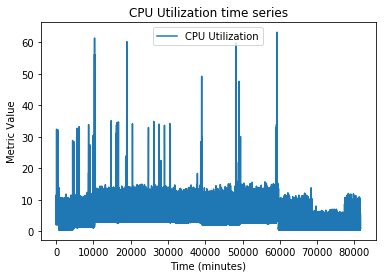

In [85]:
plt.plot(cpu_data.index, cpu_data.iloc[:,1], label = 'CPU Utilization')
plt.legend()
plt.xlabel('Time (minutes)')
plt.ylabel('Metric Value')
plt.title('CPU Utilization time series')
plt.show()

In [89]:
cpu_data.columns = ['ds', 'y', 'y2']
df = cpu_data[:60000].drop(columns=['y2'])
df.tail()

,ds,y
59995,2018-08-09 09:02:00,1.200000
59996,2018-08-09 09:03:00,0.566667
59997,2018-08-09 09:04:00,0.766667
59998,2018-08-09 09:05:00,0.766667
59999,2018-08-09 09:06:00,0.666667


In [90]:
m = Prophet()
m.fit(df)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [108]:
future = m.make_future_dataframe(periods=20000, freq = 'T')
future.tail()

,ds
79995,2018-08-23 06:22:00
79996,2018-08-23 06:23:00
79997,2018-08-23 06:24:00
79998,2018-08-23 06:25:00
79999,2018-08-23 06:26:00


In [109]:
fcst = m.predict(future)

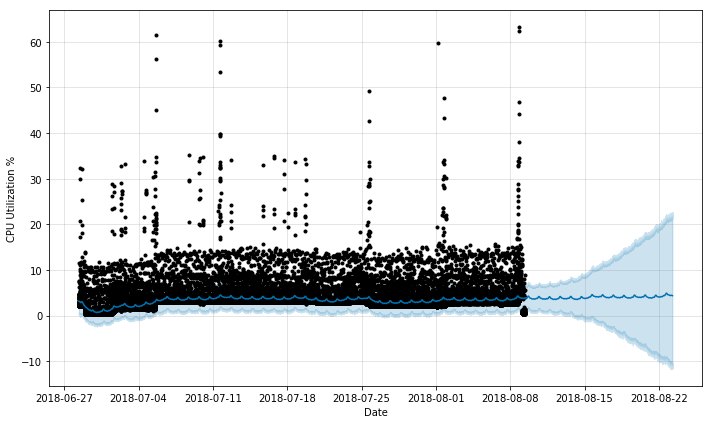

In [110]:
fig = m.plot(fcst, xlabel = 'Date', ylabel = 'CPU Utilization %')

In [113]:
test = pd.DataFrame()
test['lower'] = fcst['yhat_lower']
test['upper'] = fcst['yhat_upper']
test['cpu'] = cpu_data['y']
test.head()

,lower,upper,cpu
0,0.220261,5.802810,2.266667
1,0.326042,6.006695,2.466667
2,0.360859,5.841140,2.316667
3,0.431156,5.955509,4.700000
4,0.157936,5.881050,2.200000


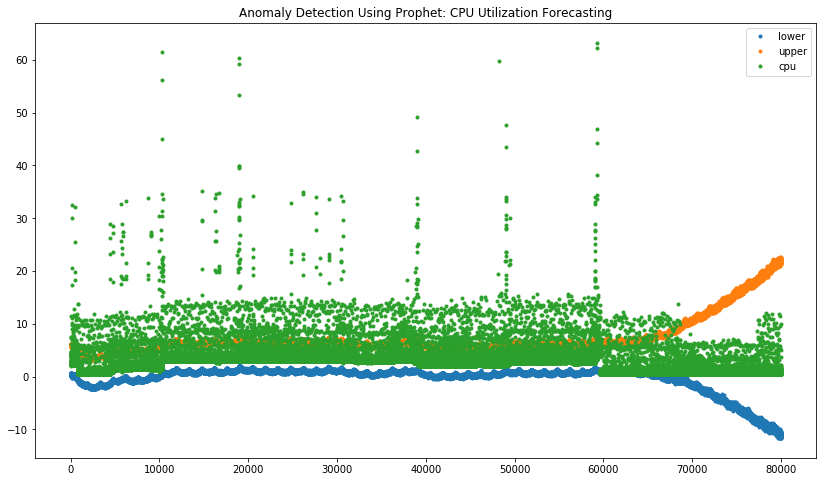

In [114]:
test.plot(style = ".", figsize = (14,8), title = "Anomaly Detection Using Prophet: CPU Utilization Forecasting")